Rank@1:0.321053 Rank@5:0.500000 Rank@10:0.542105
Rank@10:0.542105 Rank@20:0.589474 Rank@50:0.710526
mAP:0.104969


<ipython-input-14-b7d4f3bc662d>:170: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 1000)


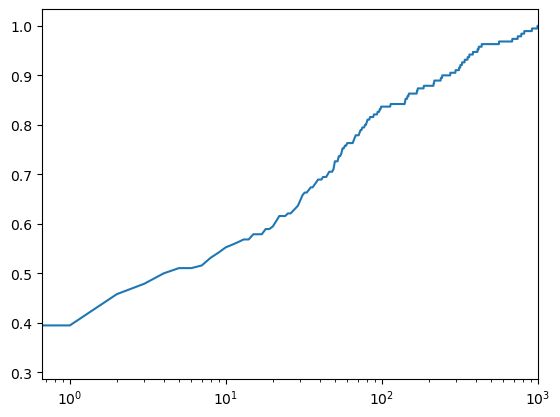

Average precision score, micro-averaged over all classes: 0.05


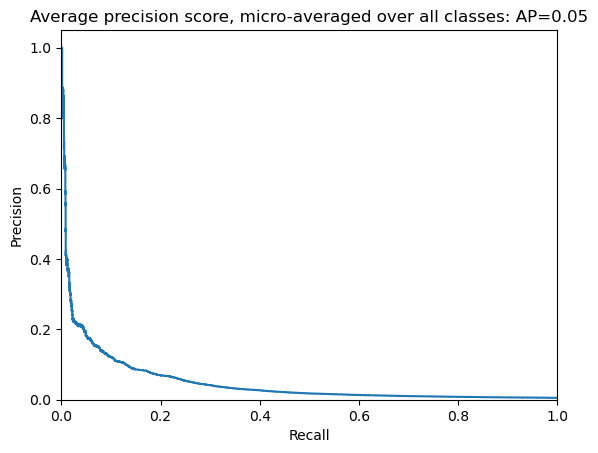

In [14]:
import pickle
from pathlib import Path


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import (average_precision_score,
                             plot_precision_recall_curve,
                             precision_recall_curve)
from tqdm import tqdm

from evaluation.utils import evaluate

In [ ]:
def load_feature_file(path):
    """
    Load features stored as dictionary with fields 'feature_mat', 'labels', and 'refs'
    :param path:
    :return:
    """
    with open(path, "rb") as fin:
        features_in = pickle.load(fin)
    mat_feat = features_in["feat_mat"]
    arr_labels = features_in["labels"]
    arr_refs = features_in["refs"]
    return mat_feat, arr_labels, arr_refs

In [ ]:
# set flags
overwrite = False
# set paths
dir_root = "/media/jrob/Seagate Backup Plus Drive/"
file_probe = f"{dir_root}rfiw2021/rfiw2021-data/track-III/test/data/lists/probe_lut.csv"
file_gallery = (
    f"{dir_root}rfiw2021/rfiw2021-data/track-III/test/data/lists/metadata_luts.csv"
)

dir_features = f"{dir_root}rfiw2021/rfiw2021-data/FIDs-features/"
path_probe_features = Path(f"{dir_root}probe_features.pkl")
path_gallery_features = Path(f"{dir_features}gallery_features.pkl")
path_features = Path(dir_features)

In [ ]:
# read in probe list (table)
df_probes = pd.read_csv(file_probe)
# add column for file pointer to average encoding for MID
df_probes["feat_path"] = df_probes.apply(
    lambda row: path_features / str(row["original"]) / "avg_encoding.npy", axis=1
)

In [ ]:
if not overwrite and path_probe_features.exists():
    # load if probe features are stored
    feat_mat, labels, refs = load_feature_file(path_probe_features)
else:
    # load all pickle files and dump to single pickle
    fpaths = df_probes.feat_path.to_list()
    feat_mat = []
    labels = np.array(df_probes["fid"].to_list())
    refs = df_probes["original"].to_list()
    for row in tqdm(df_probes.iterrows()):
        feat = np.load(str(row[1]["feat_path"]))
        feat_mat.append(feat)

    feat_mat = np.array(feat_mat)

    features = {"feat_mat": feat_mat, "labels": labels, "refs": refs}
    with open(path_probe_features, "wb") as fout:
        pickle.dump(features, fout)
    del features

In [ ]:
df_gallery = pd.read_csv(file_gallery)
df_gallery["feat_path"] = df_gallery.apply(
    lambda el: path_features / str(el["original"]).replace(".jpg", ".pkl"), axis=1
)

In [ ]:
if not overwrite and path_gallery_features.exists():
    feat_mat_gallery, labels_gallery, refs_gallery = load_feature_file(
        path_gallery_features
    )
else:
    feat_mat_gallery = []
    labels_gallery = np.array(df_gallery["fid"].to_list())
    refs_gallery = df_gallery["original"].to_list()

    for row in tqdm(df_gallery.iterrows()):
        try:
            with open(str(row[1]["feat_path"]), "rb") as file:
                feat = pickle.load(file)
            feat_mat_gallery.append(feat)
        except:
            print(str(row[1]["feat_path"]))

    feat_mat_gallery = np.array(feat_mat_gallery)
    features = {
        "feat_mat": feat_mat_gallery,
        "labels": labels_gallery,
        "refs": refs_gallery,
    }
    with open(path_gallery_features, "wb") as fout:
        pickle.dump(features, fout)
    del features

In [ ]:
## query-gallery
CMC = 0
ap = 0.0
all_scores = []
all_predicts = []
# For each class
precision = dict()
recall = dict()
average_precision = dict()
y_score = []
Y_test = []

for i in range(labels.shape[0]):
    (
        scores,
        predicts,
        (ap_tmp, CMC_tmp),
        precision[i],
        recall[i],
        average_precision[i],
        true_matches,
    ) = evaluate(feat_mat[i][None, ...], labels[i], feat_mat_gallery, labels_gallery)
    # y_score[:, i] = scores[0].T
    # Y_test[:, i] = true_matches.astype(int)
    y_score.append(scores[0])
    Y_test.append(true_matches.astype(int))
    # all_scores.append(scores.squeeze())
    all_scores.append(scores)
    all_predicts.append(predicts)
    if CMC_tmp[0] == -1:
        continue
    CMC = CMC + CMC_tmp.numpy()
    ap += ap_tmp
    # y_score = scores
    # Y_test = labels_gallery

In [ ]:
y_score = np.array(y_score)
Y_test = np.array(Y_test)
CMC = CMC.astype(float)
CMC = CMC / labels.shape[0]  # average CMC
print("Rank@1:%f Rank@5:%f Rank@10:%f" % (CMC[0], CMC[4], CMC[9]))
print("Rank@10:%f Rank@20:%f Rank@50:%f" % (CMC[9], CMC[19], CMC[49]))
print("mAP:%f" % (ap / labels.shape[0]))
all_scores = np.asarray(all_scores)
all_predicts = np.asarray(all_predicts)
# save all_scores to npy
predict_result = {
    "all_scores": all_scores,
    "Y_test": Y_test,
    "y_score": y_score,
    "all_predicts": all_predicts,
    "labels_gallery": labels_gallery,
    "labels": labels,
    "CMC": CMC,
    "precision": precision,
    "recall": recall,
    "average_precision": average_precision,
}

In [ ]:
with open("predict_result.pkl", 'wb') as file:
    pickle.dump(predict_result, file)

In [ ]:
# CMC = CMC.numpy()
fig, ax = plt.subplots()
plt.plot(CMC)
ax.set(xscale="log")
plt.xlim(0, 1000)
plt.show()
fig.savefig("CMC_result.png")

In [ ]:
# disp = plot_precision_recall_curve(classifier, X_test, y_test)
# disp.ax_.set_title('2-class Precision-Recall curve: '
#                    'AP={0:0.2f}'.format(average_precision))

In [ ]:
# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(
    Y_test.ravel(), y_score.ravel()
)
average_precision["micro"] = average_precision_score(Y_test, y_score, average="micro")
print(
    "Average precision score, micro-averaged over all classes: {0:0.2f}".format(
        average_precision["micro"]
    )
)

In [ ]:
plt.figure()
plt.step(recall["micro"], precision["micro"], where="post")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    "Average precision score, micro-averaged over all classes: AP={0:0.2f}".format(
        average_precision["micro"]
    )
)